In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.executing_eagerly())
tf.config.list_physical_devices('GPU')

True
True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
batch_size = 2
img_height = 1500
img_width = 1500

In [4]:
data_dir = "archive/tiff/"
print(os.listdir(data_dir))

['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']


In [5]:
bmp = "archive/bmp/"
folders = os.listdir(bmp)
filenames =  [[],[],[],[],[],[]]
i=0
for folder in folders:
    images = os.listdir(bmp + folder)
    for image in images:
        filenames[i].append(str(bmp + folder + "/" + image))
    i += 1
test, test_labels, train, train_labels, val, val_labels = filenames

In [6]:
def read_filenames(filepath1, filepath2):
    pil_image1 =  tf.io.read_file(filepath1)
    image1 = tf.io.decode_bmp(pil_image1, channels=0)
    pil_image2 =  tf.io.read_file(filepath2)
    image2 = tf.io.decode_bmp(pil_image2, channels=0)
    return (image1,image2)

In [7]:
class DataReader():
    def __init__(self, filenames1, filenames2, batch_size):
        # filenames: list of files
        self.filenames1 = filenames1
        self.filenames2 = filenames2
        self.dataset = None
        print("{} filenames received".format(len(filenames1)))
        print("{} filenames received".format(len(filenames2)))
        self.batch_size = batch_size
        self.run()
        
    def read_filenames(self, filepath1, filepath2):
        pil_image1 =  tf.io.read_file(filepath1)
        image1 = tf.io.decode_bmp(pil_image1, channels=0)
        image1 = tf.image.resize(image1, [500,500])
        image1 = tf.cast(image1, tf.int32)
        pil_image2 =  tf.io.read_file(filepath2)
        image2 = tf.io.decode_bmp(pil_image2, channels=0)
        image2 = tf.image.resize(image2, [500,500])
        image2 = tf.keras.backend.flatten(image2)
        image2 = tf.cast(image2, tf.int32)
        return (image1,image2)

    def run(self):
        self.dataset = tf.data.Dataset.from_tensor_slices((self.filenames1, self.filenames2))
        self.dataset = self.dataset.shuffle(3, reshuffle_each_iteration=True)
        self.dataset = self.dataset.map(self.read_filenames, num_parallel_calls=10)
        self.dataset = self.dataset.batch(self.batch_size)
#         self.dataset = self.dataset.prefetch(1)
        return self.dataset

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((test, test_labels))
# print(list(dataset.take(3).as_numpy_iterator()))
dataset = dataset.shuffle(3, reshuffle_each_iteration=True)
dataset = dataset.map(read_filenames, num_parallel_calls=10)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)
# print(list(dataset.take(3).as_numpy_iterator()))

In [9]:
test_data = DataReader(test, test_labels, batch_size)
# print(list(test_data.dataset.take(1).as_numpy_iterator())[0].shape)
# test_labels_data = DataReader(test_labels, batch_size)
train_data = DataReader(train,train_labels, batch_size)
# train_labels_data = DataReader(train_labels, batch_size)
val_data = DataReader(val,val_labels, batch_size)
# val_labels_data = DataReader(val_labels, batch_size)

49 filenames received
49 filenames received
1108 filenames received
1108 filenames received
14 filenames received
14 filenames received


## Show some images

(2, 500, 500, 3)


IndexError: index 2 is out of bounds for axis 0 with size 2

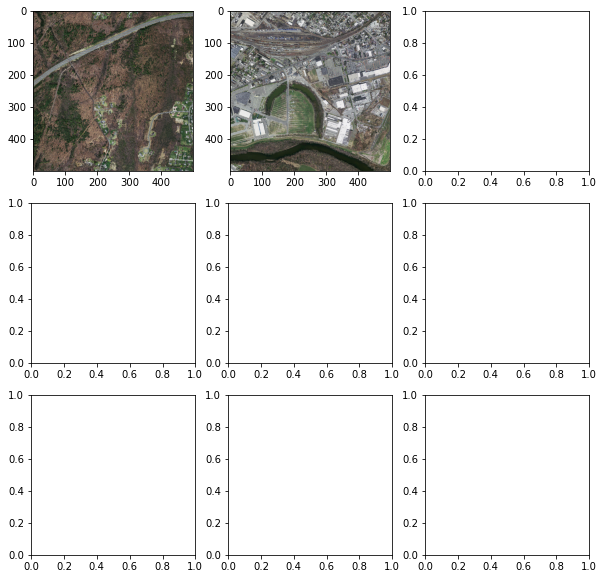

In [10]:
# Test data
fig, axs = plt.subplots(3, 3)
fig.set_figheight(10)
fig.set_figwidth(10)
x = list(test_data.dataset.take(9).as_numpy_iterator())[0][:9]
print(x[0].shape)
index = 0
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(x[0][index,:,:,:])
        index += 1

In [ ]:
# Test Labels data
fig, axs = plt.subplots(3, 3)
fig.set_figheight(10)
fig.set_figwidth(10)
x = list(test_data.dataset.take(9).as_numpy_iterator())[0][:9]
index = 0
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(x[index])
        index += 1

## Inspection of the shape of our data

In [10]:
print("Input data = {}".format(list(test_data.dataset.take(1).as_numpy_iterator())[0][0].shape))
print("Output data = {}".format(list(test_data.dataset.take(1).as_numpy_iterator())[0][1].shape))

Input data = (2, 500, 500, 3)
Output data = (2, 250000)


In [13]:
## Check to see that the data is one hot encoded

In [11]:
x = list(test_data.dataset.take(1).as_numpy_iterator())[0][1]
print(x.shape)
np.unique(x, return_counts=True)

(2, 250000)


(array([  0, 255]), array([480570,  19430], dtype=int64))

# Model Creation (Figure out how to set the final output: 2 classes or 1000x1000 ?)

In [28]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec, Layer
class Argmax(Layer):
    """
    Based on https://github.com/YerevaNN/R-NET-in-Keras/blob/master/layers/Argmax.py
    """
    def __init__(self, axis=-1, **kwargs):
        super(Argmax, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis

    def call(self, inputs, mask=None):
        return tf.cast(K.argmax(inputs, axis=self.axis), tf.float32)

    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        del input_shape[self.axis]
        return tuple(input_shape)

    def compute_mask(self, x, mask):
        return None

    def get_config(self):
        config = {'axis': self.axis}
        base_config = super(Argmax, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [16]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(500,500,3), classes=2)
model = tf.keras.Sequential([ resnet,
        tf.keras.layers.Conv2D(1000, 5, padding='same'),
        tf.keras.layers.Conv2D(512, 5),
        tf.keras.layers.Conv2D(256, 3),
#         tf.keras.layers.Conv2D(100, 5),
#         tf.keras.layers.Conv2D(50, 5),
#         tf.keras.layers.Conv2D(30, 5),
#         tf.keras.layers.Conv2D(15, 3),                     
        tf.keras.layers.Dense(5000, activation='sigmoid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Reshape((250000, 2)),
#         Argmax()
        tf.keras.layers.Lambda(lambda x: tf.keras.backend.argmax(x))
                            ])


In [17]:
model.summary()
500*500

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 1000)      51201000  
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 512)       12800512  
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 256)       1179904   
_________________________________________________________________
dense_3 (Dense)              (None, 10, 10, 5000)      1285000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 500000)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 250000, 2)        

250000

In [17]:
def myLoss(y_true, y_pred):
#     flatten = tf.keras.backend.flatten(y_pred)
    reshaped = tf.keras.backend.reshape(y_pred, (-1,2))
    argmax = tf.cast(tf.keras.backend.argmax(reshaped), tf.int32)
    print(y_true)
    print(argmax)
    loss = tf.keras.losses.mean_squared_error(y_true, argmax)
    return loss
    
# loss_fn = tf.keras.losses.MeanSquaredError()


In [18]:
model.compile(optimizer='adam',
              loss="mse",
              metrics=['accuracy'])

In [93]:
# for layer in model.layers:
#     layer.add_loss(losses=tf.keras.losses.MeanSquaredError())

In [19]:
model.fit(train_data.dataset, verbose=1, epochs=5)

Epoch 1/5


ValueError: in user code:

    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.trainable_variables)
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\keras\engine\training.py:2737 _minimize
        trainable_variables))
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    c:\users\anike\anaconda3\envs\final_mmd\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['conv1_conv/kernel:0', 'conv1_conv/bias:0', 'conv1_bn/gamma:0', 'conv1_bn/beta:0', 'conv2_block1_1_conv/kernel:0', 'conv2_block1_1_conv/bias:0', 'conv2_block1_1_bn/gamma:0', 'conv2_block1_1_bn/beta:0', 'conv2_block1_2_conv/kernel:0', 'conv2_block1_2_conv/bias:0', 'conv2_block1_2_bn/gamma:0', 'conv2_block1_2_bn/beta:0', 'conv2_block1_0_conv/kernel:0', 'conv2_block1_0_conv/bias:0', 'conv2_block1_3_conv/kernel:0', 'conv2_block1_3_conv/bias:0', 'conv2_block1_0_bn/gamma:0', 'conv2_block1_0_bn/beta:0', 'conv2_block1_3_bn/gamma:0', 'conv2_block1_3_bn/beta:0', 'conv2_block2_1_conv/kernel:0', 'conv2_block2_1_conv/bias:0', 'conv2_block2_1_bn/gamma:0', 'conv2_block2_1_bn/beta:0', 'conv2_block2_2_conv/kernel:0', 'conv2_block2_2_conv/bias:0', 'conv2_block2_2_bn/gamma:0', 'conv2_block2_2_bn/beta:0', 'conv2_block2_3_conv/kernel:0', 'conv2_block2_3_conv/bias:0', 'conv2_block2_3_bn/gamma:0', 'conv2_block2_3_bn/beta:0', 'conv2_block3_1_conv/kernel:0', 'conv2_block3_1_conv/bias:0', 'conv2_block3_1_bn/gamma:0', 'conv2_block3_1_bn/beta:0', 'conv2_block3_2_conv/kernel:0', 'conv2_block3_2_conv/bias:0', 'conv2_block3_2_bn/gamma:0', 'conv2_block3_2_bn/beta:0', 'conv2_block3_3_conv/kernel:0', 'conv2_block3_3_conv/bias:0', 'conv2_block3_3_bn/gamma:0', 'conv2_block3_3_bn/beta:0', 'conv3_block1_1_conv/kernel:0', 'conv3_block1_1_conv/bias:0', 'conv3_block1_1_bn/gamma:0', 'conv3_block1_1_bn/beta:0', 'conv3_block1_2_conv/kernel:0', 'conv3_block1_2_conv/bias:0', 'conv3_block1_2_bn/gamma:0', 'conv3_block1_2_bn/beta:0', 'conv3_block1_0_conv/kernel:0', 'conv3_block1_0_conv/bias:0', 'conv3_block1_3_conv/kernel:0', 'conv3_block1_3_conv/bias:0', 'conv3_block1_0_bn/gamma:0', 'conv3_block1_0_bn/beta:0', 'conv3_block1_3_bn/gamma:0', 'conv3_block1_3_bn/beta:0', 'conv3_block2_1_conv/kernel:0', 'conv3_block2_1_conv/bias:0', 'conv3_block2_1_bn/gamma:0', 'conv3_block2_1_bn/beta:0', 'conv3_block2_2_conv/kernel:0', 'conv3_block2_2_conv/bias:0', 'conv3_block2_2_bn/gamma:0', 'conv3_block2_2_bn/beta:0', 'conv3_block2_3_conv/kernel:0', 'conv3_block2_3_conv/bias:0', 'conv3_block2_3_bn/gamma:0', 'conv3_block2_3_bn/beta:0', 'conv3_block3_1_conv/kernel:0', 'conv3_block3_1_conv/bias:0', 'conv3_block3_1_bn/gamma:0', 'conv3_block3_1_bn/beta:0', 'conv3_block3_2_conv/kernel:0', 'conv3_block3_2_conv/bias:0', 'conv3_block3_2_bn/gamma:0', 'conv3_block3_2_bn/beta:0', 'conv3_block3_3_conv/kernel:0', 'conv3_block3_3_conv/bias:0', 'conv3_block3_3_bn/gamma:0', 'conv3_block3_3_bn/beta:0', 'conv3_block4_1_conv/kernel:0', 'conv3_block4_1_conv/bias:0', 'conv3_block4_1_bn/gamma:0', 'conv3_block4_1_bn/beta:0', 'conv3_block4_2_conv/kernel:0', 'conv3_block4_2_conv/bias:0', 'conv3_block4_2_bn/gamma:0', 'conv3_block4_2_bn/beta:0', 'conv3_block4_3_conv/kernel:0', 'conv3_block4_3_conv/bias:0', 'conv3_block4_3_bn/gamma:0', 'conv3_block4_3_bn/beta:0', 'conv4_block1_1_conv/kernel:0', 'conv4_block1_1_conv/bias:0', 'conv4_block1_1_bn/gamma:0', 'conv4_block1_1_bn/beta:0', 'conv4_block1_2_conv/kernel:0', 'conv4_block1_2_conv/bias:0', 'conv4_block1_2_bn/gamma:0', 'conv4_block1_2_bn/beta:0', 'conv4_block1_0_conv/kernel:0', 'conv4_block1_0_conv/bias:0', 'conv4_block1_3_conv/kernel:0', 'conv4_block1_3_conv/bias:0', 'conv4_block1_0_bn/gamma:0', 'conv4_block1_0_bn/beta:0', 'conv4_block1_3_bn/gamma:0', 'conv4_block1_3_bn/beta:0', 'conv4_block2_1_conv/kernel:0', 'conv4_block2_1_conv/bias:0', 'conv4_block2_1_bn/gamma:0', 'conv4_block2_1_bn/beta:0', 'conv4_block2_2_conv/kernel:0', 'conv4_block2_2_conv/bias:0', 'conv4_block2_2_bn/gamma:0', 'conv4_block2_2_bn/beta:0', 'conv4_block2_3_conv/kernel:0', 'conv4_block2_3_conv/bias:0', 'conv4_block2_3_bn/gamma:0', 'conv4_block2_3_bn/beta:0', 'conv4_block3_1_conv/kernel:0', 'conv4_block3_1_conv/bias:0', 'conv4_block3_1_bn/gamma:0', 'conv4_block3_1_bn/beta:0', 'conv4_block3_2_conv/kernel:0', 'conv4_block3_2_conv/bias:0', 'conv4_block3_2_bn/gamma:0', 'conv4_block3_2_bn/beta:0', 'conv4_block3_3_conv/kernel:0', 'conv4_block3_3_conv/bias:0', 'conv4_block3_3_bn/gamma:0', 'conv4_block3_3_bn/beta:0', 'conv4_block4_1_conv/kernel:0', 'conv4_block4_1_conv/bias:0', 'conv4_block4_1_bn/gamma:0', 'conv4_block4_1_bn/beta:0', 'conv4_block4_2_conv/kernel:0', 'conv4_block4_2_conv/bias:0', 'conv4_block4_2_bn/gamma:0', 'conv4_block4_2_bn/beta:0', 'conv4_block4_3_conv/kernel:0', 'conv4_block4_3_conv/bias:0', 'conv4_block4_3_bn/gamma:0', 'conv4_block4_3_bn/beta:0', 'conv4_block5_1_conv/kernel:0', 'conv4_block5_1_conv/bias:0', 'conv4_block5_1_bn/gamma:0', 'conv4_block5_1_bn/beta:0', 'conv4_block5_2_conv/kernel:0', 'conv4_block5_2_conv/bias:0', 'conv4_block5_2_bn/gamma:0', 'conv4_block5_2_bn/beta:0', 'conv4_block5_3_conv/kernel:0', 'conv4_block5_3_conv/bias:0', 'conv4_block5_3_bn/gamma:0', 'conv4_block5_3_bn/beta:0', 'conv4_block6_1_conv/kernel:0', 'conv4_block6_1_conv/bias:0', 'conv4_block6_1_bn/gamma:0', 'conv4_block6_1_bn/beta:0', 'conv4_block6_2_conv/kernel:0', 'conv4_block6_2_conv/bias:0', 'conv4_block6_2_bn/gamma:0', 'conv4_block6_2_bn/beta:0', 'conv4_block6_3_conv/kernel:0', 'conv4_block6_3_conv/bias:0', 'conv4_block6_3_bn/gamma:0', 'conv4_block6_3_bn/beta:0', 'conv5_block1_1_conv/kernel:0', 'conv5_block1_1_conv/bias:0', 'conv5_block1_1_bn/gamma:0', 'conv5_block1_1_bn/beta:0', 'conv5_block1_2_conv/kernel:0', 'conv5_block1_2_conv/bias:0', 'conv5_block1_2_bn/gamma:0', 'conv5_block1_2_bn/beta:0', 'conv5_block1_0_conv/kernel:0', 'conv5_block1_0_conv/bias:0', 'conv5_block1_3_conv/kernel:0', 'conv5_block1_3_conv/bias:0', 'conv5_block1_0_bn/gamma:0', 'conv5_block1_0_bn/beta:0', 'conv5_block1_3_bn/gamma:0', 'conv5_block1_3_bn/beta:0', 'conv5_block2_1_conv/kernel:0', 'conv5_block2_1_conv/bias:0', 'conv5_block2_1_bn/gamma:0', 'conv5_block2_1_bn/beta:0', 'conv5_block2_2_conv/kernel:0', 'conv5_block2_2_conv/bias:0', 'conv5_block2_2_bn/gamma:0', 'conv5_block2_2_bn/beta:0', 'conv5_block2_3_conv/kernel:0', 'conv5_block2_3_conv/bias:0', 'conv5_block2_3_bn/gamma:0', 'conv5_block2_3_bn/beta:0', 'conv5_block3_1_conv/kernel:0', 'conv5_block3_1_conv/bias:0', 'conv5_block3_1_bn/gamma:0', 'conv5_block3_1_bn/beta:0', 'conv5_block3_2_conv/kernel:0', 'conv5_block3_2_conv/bias:0', 'conv5_block3_2_bn/gamma:0', 'conv5_block3_2_bn/beta:0', 'conv5_block3_3_conv/kernel:0', 'conv5_block3_3_conv/bias:0', 'conv5_block3_3_bn/gamma:0', 'conv5_block3_3_bn/beta:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'conv2d_10/kernel:0', 'conv2d_10/bias:0', 'conv2d_11/kernel:0', 'conv2d_11/bias:0', 'dense_3/kernel:0', 'dense_3/bias:0'].


In [27]:
tf.trainable_variables()

AttributeError: module 'tensorflow' has no attribute 'trainable_variables'

In [21]:
x = tuple(train_data.dataset.take(1))[0][1]
loss_fn(x,x)
# model(tuple(train_data.dataset.take(1))[0][0])
# tuple(train_data.dataset.take(1))[0][1]

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [46]:
test_result = model.predict(tuple(train_data.dataset.take(1))[0][0][:1]).reshape((500,500))
plt.imshow(test_result)
# tuple(train_data.dataset.take(1))[0][0][:1]

ValueError: cannot reshape array of size 200 into shape (500,500)

In [30]:
# tf.image.resize(tuple(train_data.dataset.take(1))[0][1][:1], [500,500])
tuple(train_data.dataset.take(1))[0][1][:1]

<tf.Tensor: shape=(1, 2250000), dtype=int32, numpy=array([[0, 0, 0, ..., 0, 0, 0]])>